In [1203]:
import dotenv
import os

dotenv.load_dotenv()
import matplotlib.pyplot as plt
%matplotlib inline

from typing import List, Tuple

import random
import numpy

In [1204]:
from utils.frameReader import FrameReader
from utils.predictor import GVLPredictor
from utils.visualiser import GVLVisualizer
from utils.vlm import ClaudeVLM, OpenAIVLM, GeminiVLM

In [1205]:
order = 'unshuffled'


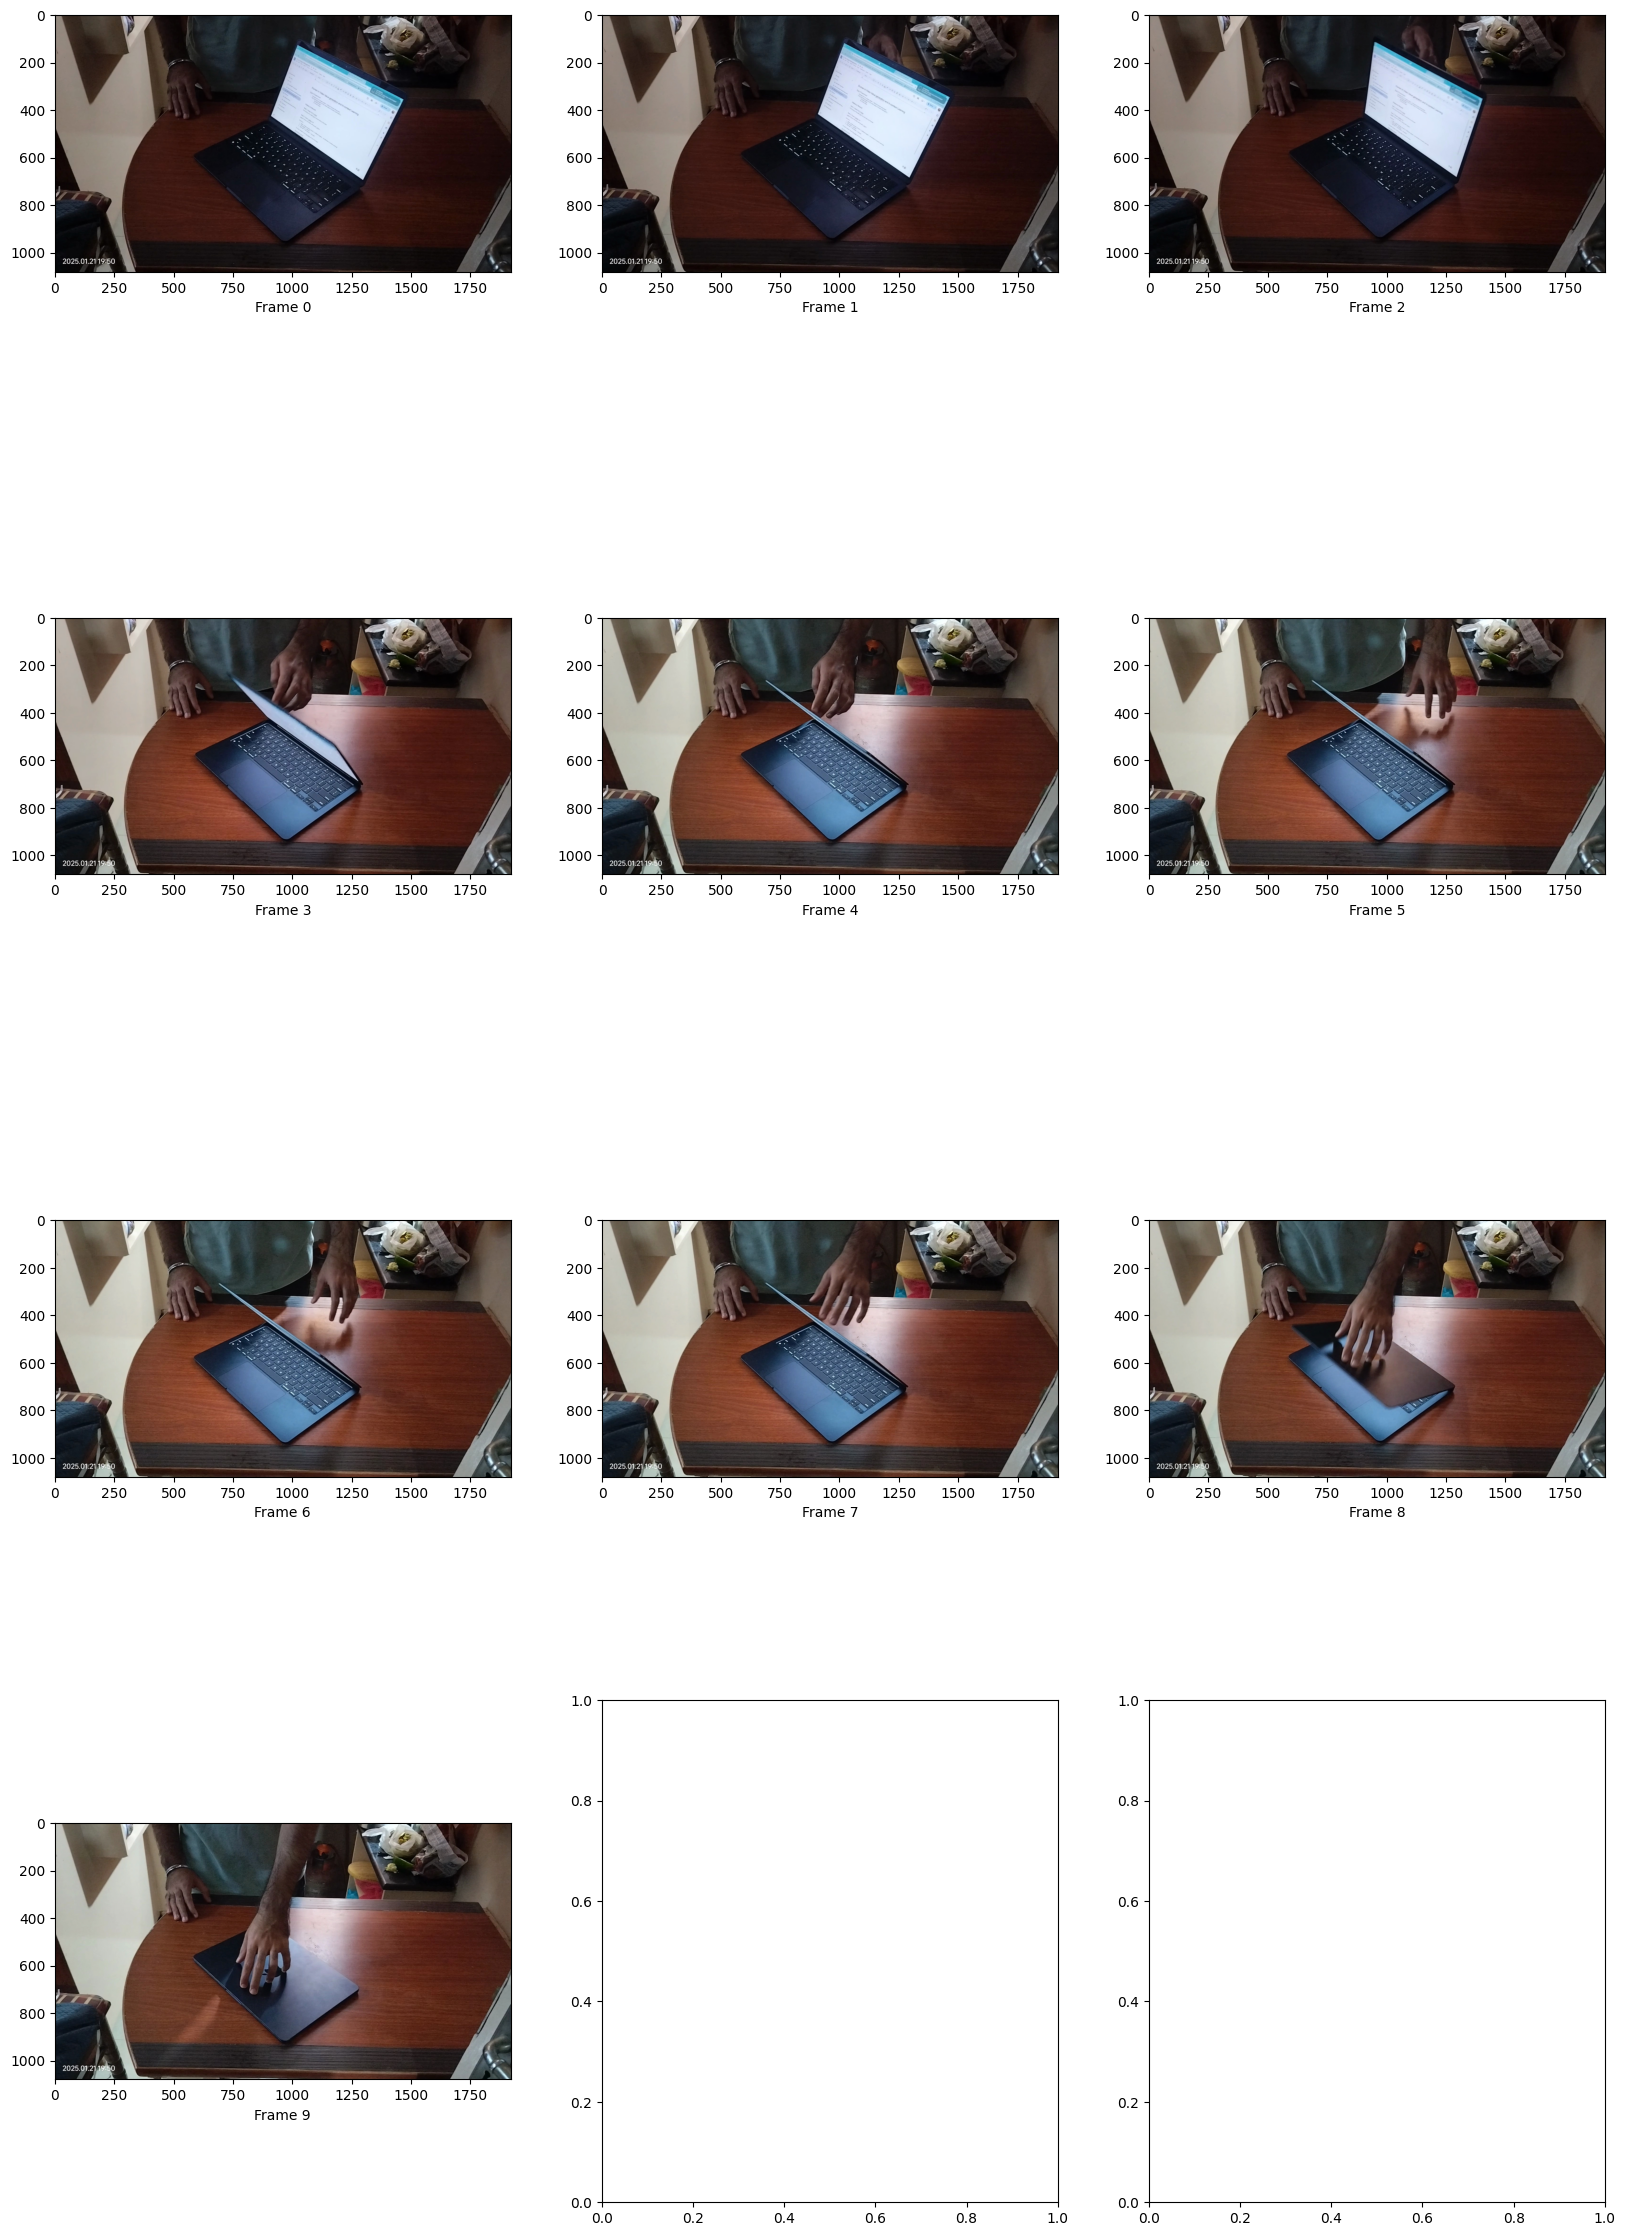

In [1206]:
image_columns = 3

# Read frames
frames_dir = "data/frames/laptop_fail_success_2"
frames = FrameReader.read_frames_from_dir(frames_dir)

num_frames = len(frames)
fig, ax = plt.subplots(num_frames//image_columns + 1, image_columns, figsize=(20, 30))
c = 0
for i, ix in enumerate(frames):
    ax[c//image_columns][c%image_columns].imshow(ix)
    #set x label
    ax[c//image_columns][c%image_columns].set_xlabel(f"Frame {i}")

    c+=1

In [1207]:
def shuffle_frames(
    frames: List, keep_first: bool = True
) -> Tuple[List, List]:
    """Shuffle frames while optionally keeping first frame fixed."""
    if keep_first:
        first_frame = frames[0]
        remaining_frames = frames[1:]
        shuffled_indices = list(range(1, len(frames)))
        random.shuffle(shuffled_indices)

        shuffled_frames = [first_frame] + [frames[i] for i in shuffled_indices]
        indices = [0] + shuffled_indices
    else:
        shuffled_indices = list(range(len(frames)))
        random.shuffle(shuffled_indices)
        shuffled_frames = [frames[i] for i in shuffled_indices]
        indices = shuffled_indices

    return shuffled_frames, indices

In [1208]:
# shuffled_frames, indices = shuffle_frames(frames)
shuffled_frames = frames


In [1209]:
# fig, ax = plt.subplots(num_frames//image_columns + 1, image_columns, figsize=(20, 30))
# c = 0
# for i, ix in enumerate(shuffled_frames):
#     ax[c//image_columns][c%image_columns].imshow(ix)
#     #set x label
#     ax[c//image_columns][c%image_columns].set_xlabel(f"Frame {i}")

#     c+=1

In [1210]:
import io

In [1211]:
import base64

import google.generativeai as genai
from IPython.display import Markdown
from PIL import Image

# Assuming you have the following:
# - list_pil_images: list of PIL images
# - list_base64_images: list of base64 encoded strings of the images
# - task_description: string describing the task

# Prepare the prompt with the task description
prompt_template = """
You are an expert roboticist tasked to predict task completion percentages for frames of a robot for the task of {task_description}. You are given {num_frames} frames.
The task completion percentages are between 0 and 100, where 100 corresponds to full task completion. Note that these frames are in random order, so please pay attention to the individual frames when reasoning about task completion percentage.
Initial robot scene: [IMG]
In the initial robot scene, the task completion percentage is 0.

Now, for the task of '{task_description}', output the task completion percentage for the following frames that are presented in random order. For each frame, format your response as follow: 
Frame [i]: Frame Description: [], Task Completion Percentages:[]%
Frame [1]: [IMG]
...
Frame [n]: [IMG]
"""


In [1212]:
task_description = "close the laptop lid. the lid should be closed to completion."

In [1213]:
def image_to_base64(image: Image.Image, format="JPEG") -> str:
    buffer = io.BytesIO()
    image.save(buffer, format=format)
    img_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return img_str


In [1214]:
correct_order = [i for i in range(len(frames))]

In [1215]:
# shuffled_frames = frames if order =='unshuffled' else shuffled_frames

In [1216]:
list_base64_images = [image_to_base64(Image.fromarray(numpy.array(ix))) for ix in shuffled_frames]

In [1217]:
key = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=key)
model = genai.GenerativeModel(model_name="gemini-2.0-flash-exp")


In [1218]:
prompt = prompt_template.format(task_description=task_description, num_frames=len(frames))

In [1219]:
print(prompt)


You are an expert roboticist tasked to predict task completion percentages for frames of a robot for the task of close the laptop lid. the lid should be closed to completion.. You are given 10 frames.
The task completion percentages are between 0 and 100, where 100 corresponds to full task completion. Note that these frames are in random order, so please pay attention to the individual frames when reasoning about task completion percentage.
Initial robot scene: [IMG]
In the initial robot scene, the task completion percentage is 0.

Now, for the task of 'close the laptop lid. the lid should be closed to completion.', output the task completion percentage for the following frames that are presented in random order. For each frame, format your response as follow: 
Frame [i]: Frame Description: [], Task Completion Percentages:[]%
Frame [1]: [IMG]
...
Frame [n]: [IMG]



In [1220]:
import typing_extensions as typing

class TaskProgress(typing.TypedDict):
    frame_n: int
    discription: str
    completion_percentage: int

In [1221]:
len(list_base64_images)

10

In [1222]:
# Prepare the list of images for the LLM
images_for_llm = []
for base64_image in list_base64_images:
    image_dict = {
        'mime_type': 'image/jpeg',  # Adjust MIME type if necessary
        'data': base64_image
    }
    images_for_llm.append(image_dict)

# Insert the initial scene image at the beginning
# initial_image_base64 = list_base64_images[0]  # Assuming the first image is the initial scene
# images_for_llm.insert(0, {
#     'mime_type': 'image/jpeg',
#     'data': initial_image_base64
# })

generation_config={"response_mime_type": "application/json",
                   "response_schema": list[TaskProgress]}

print(f"sending {len(images_for_llm)} images to the model")

# Generate content using the model
response = model.generate_content([prompt] + images_for_llm)

# Print the response
print(response.text)

sending 10 images to the model
Okay, I'm ready to analyze the frames and provide task completion percentages for closing the laptop lid.

Frame 1: Frame Description: [The laptop lid is fully open. The screen is on and displaying a document], Task Completion Percentages:[0]%
Frame 2: Frame Description: [The laptop lid is slightly closed, but the angle of the screen to the keyboard is still greater than 90 degrees.], Task Completion Percentages:[30]%
Frame 3: Frame Description: [The laptop lid is even more closed than the last image. The angle of the screen to the keyboard is now less than 90 degrees.], Task Completion Percentages:[60]%
Frame 4: Frame Description: [The laptop lid is almost fully closed, with just a small gap remaining], Task Completion Percentages:[90]%
Frame 5: Frame Description: [The laptop lid is completely closed. The screen is no longer visible.], Task Completion Percentages:[100]%
Frame 6: Frame Description: [The laptop lid is still almost fully closed, but has not

In [1223]:
import json

lines = response.text.strip().split('\n')

frames_output = []

for line in lines:
    if line.startswith('Frame '):
        # Extract frame number
        frame_no = int(line.split(':')[0].split(' ')[1])
        # Extract description
        description_start = line.find('Frame Description: [') + len('Frame Description: [')
        description_end = line.find('], Task Completion Percentages:')
        description = line[description_start:description_end]
        # Extract percentage
        percentage_start = line.find('Task Completion Percentages:[') + len('Task Completion Percentages:[')
        percentage_end = line.find(']%', percentage_start)
        percentage = int(line[percentage_start:percentage_end])
        # Create dictionary and append to list
        frame = {
            "frame_no": frame_no,
            "description": description,
            "percentage": percentage
        }
        frames_output.append(frame)

# Convert to JSON
json_output = json.dumps(frames_output, indent=4)
print(json_output)

[
    {
        "frame_no": 1,
        "description": "The laptop lid is fully open. The screen is on and displaying a document",
        "percentage": 0
    },
    {
        "frame_no": 2,
        "description": "The laptop lid is slightly closed, but the angle of the screen to the keyboard is still greater than 90 degrees.",
        "percentage": 30
    },
    {
        "frame_no": 3,
        "description": "The laptop lid is even more closed than the last image. The angle of the screen to the keyboard is now less than 90 degrees.",
        "percentage": 60
    },
    {
        "frame_no": 4,
        "description": "The laptop lid is almost fully closed, with just a small gap remaining",
        "percentage": 90
    },
    {
        "frame_no": 5,
        "description": "The laptop lid is completely closed. The screen is no longer visible.",
        "percentage": 100
    },
    {
        "frame_no": 6,
        "description": "The laptop lid is still almost fully closed, but has not y

In [1224]:
#lambda function for descriptions
#add \n after every nth character in description
add_newline = lambda x, n: '\n'.join([x[i:i+n] for i in range(0, len(x), n)])



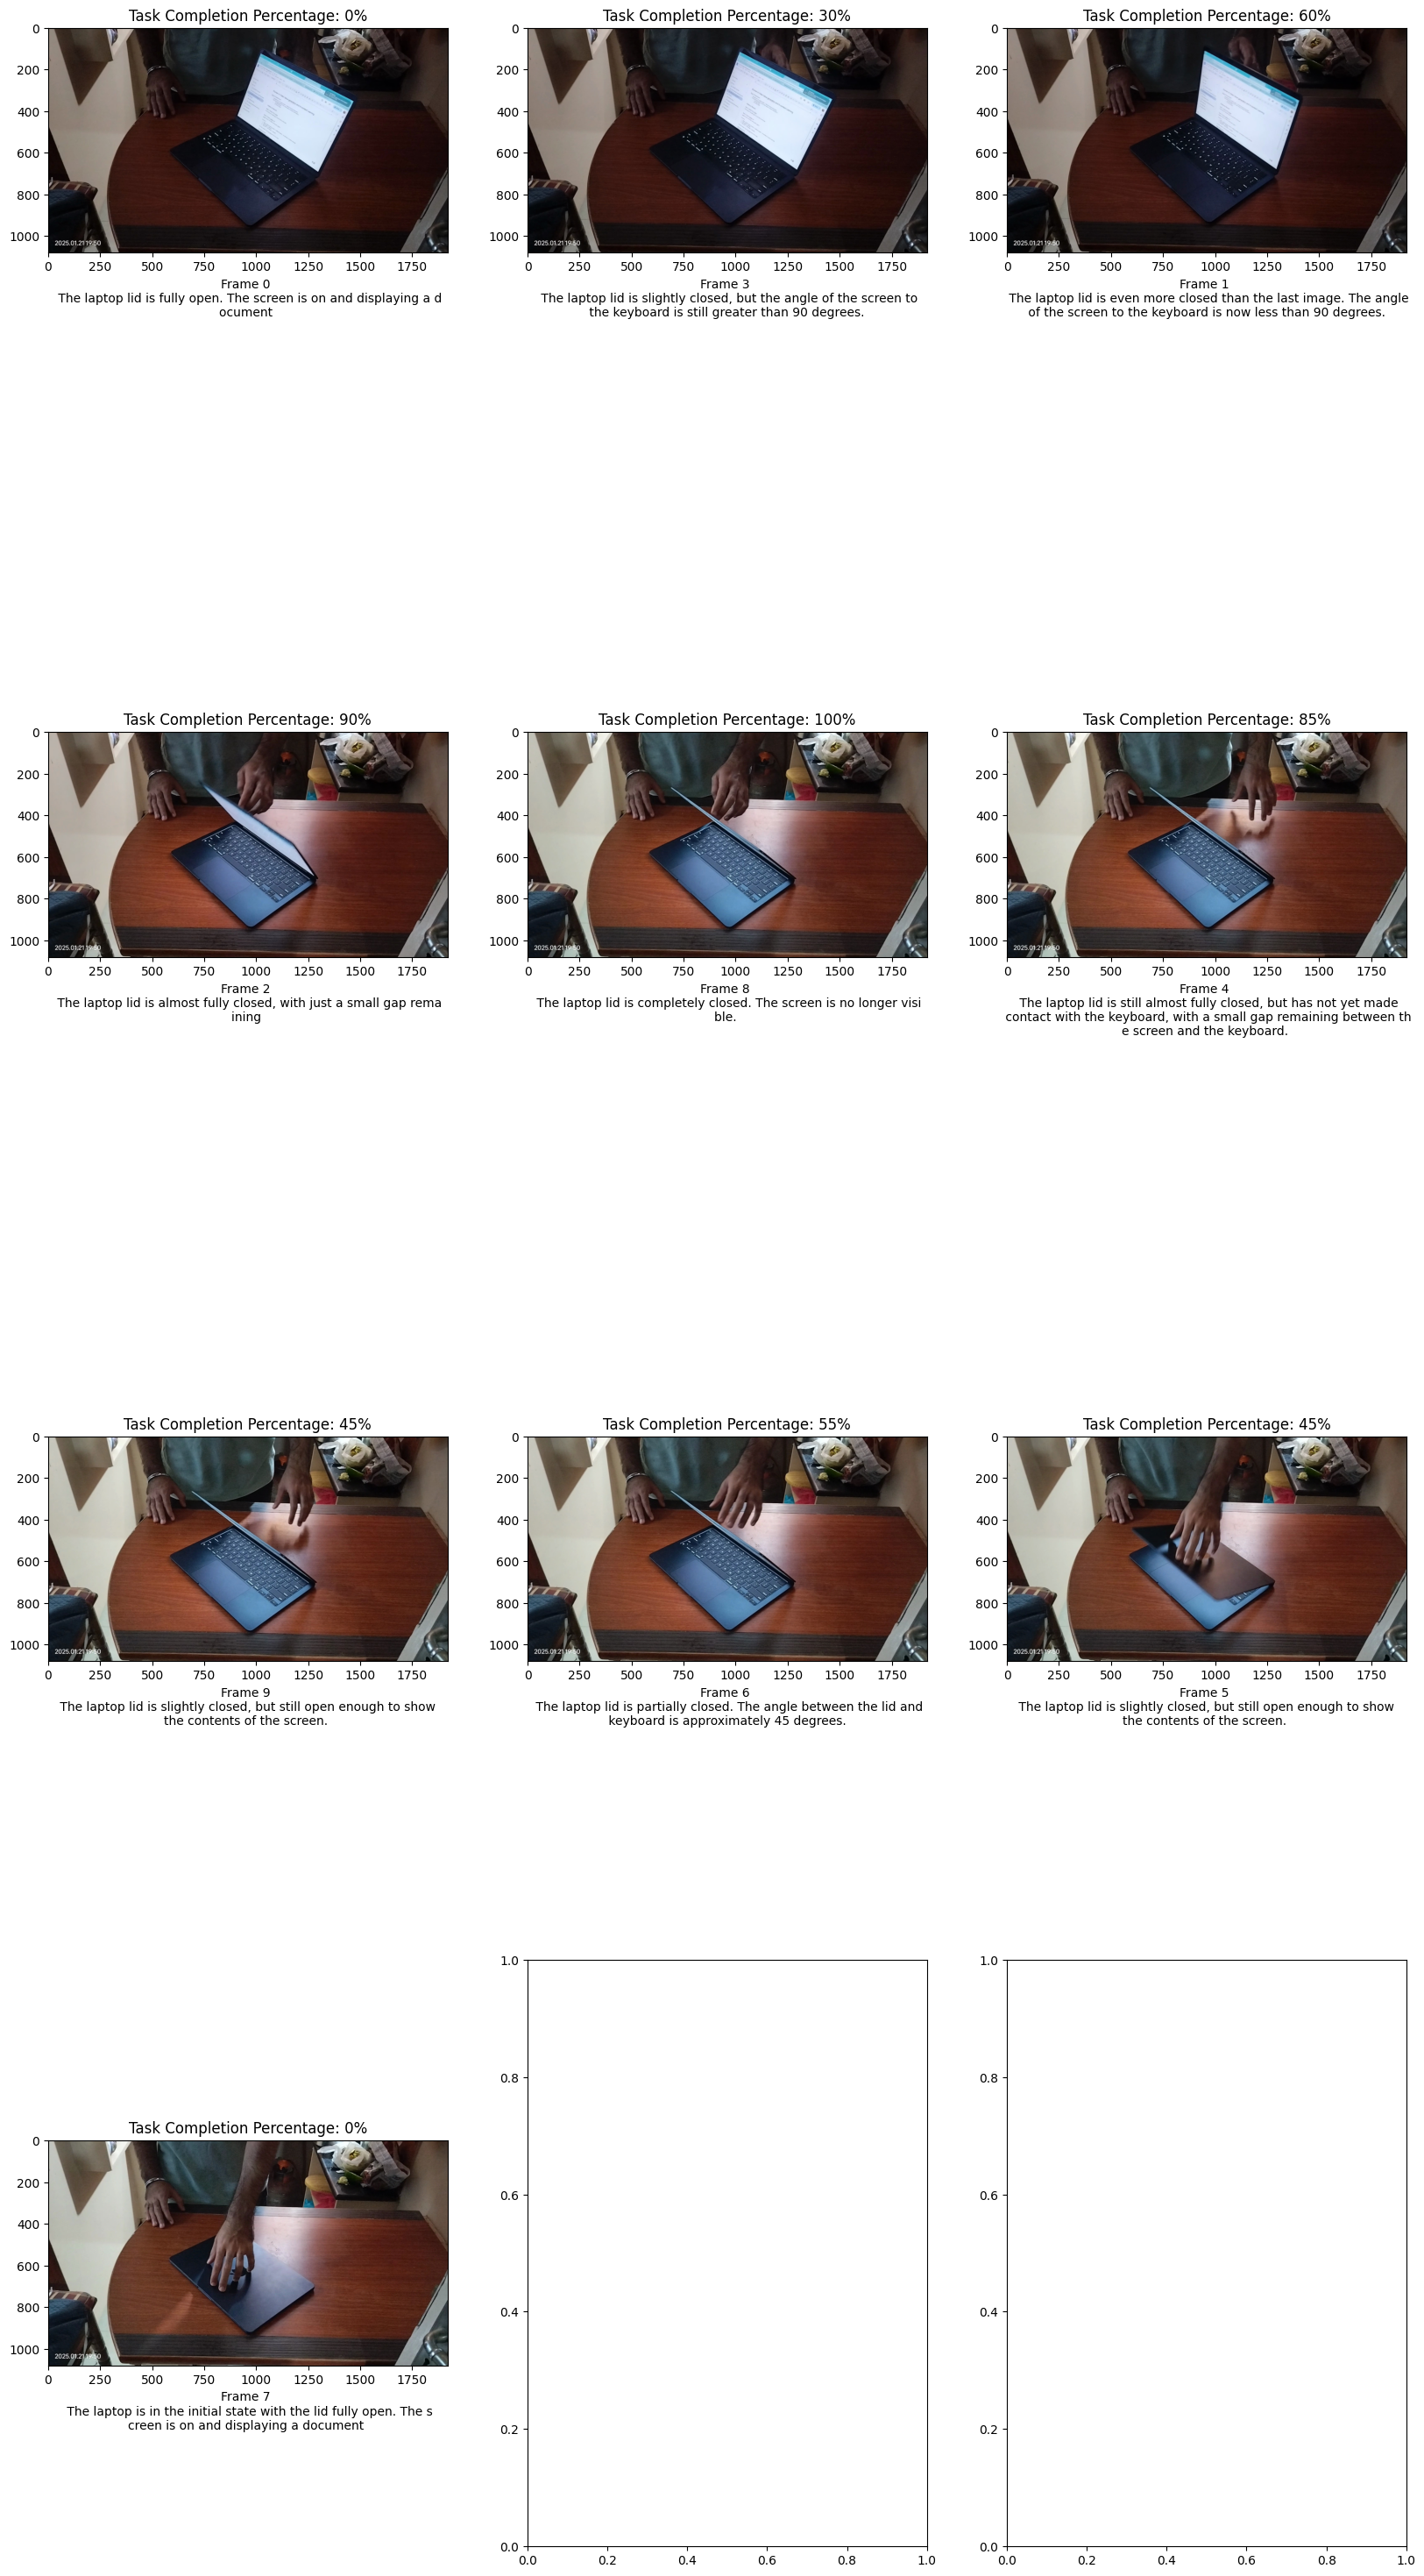

In [1225]:
fig, ax = plt.subplots(num_frames//image_columns + 1, image_columns, figsize=(20, 40))
c = 0
for i, (image, indice, json_obj) in enumerate(zip(shuffled_frames, indices, frames_output)):
    ax[c//image_columns][c%image_columns].imshow(image)
    #set x label
    ax[c//image_columns][c%image_columns].set_xlabel(f"Frame {indice} \n {add_newline(json_obj['description'], 65)} \n")
    
    ax[c//image_columns][c%image_columns].title.set_text(f"Task Completion Percentage: {json_obj['percentage']}%")
    c+=1

In [1226]:
import pandas as pd


df = pd.DataFrame(frames_output)
df['true_frame'] = indices if order == 'shuffled' else df['frame_no']
df

frame_no                                        description  percentage  \
0         1  The laptop lid is fully open. The screen is on...           0   
1         2  The laptop lid is slightly closed, but the ang...          30   
2         3  The laptop lid is even more closed than the la...          60   
3         4  The laptop lid is almost fully closed, with ju...          90   
4         5  The laptop lid is completely closed. The scree...         100   
5         6  The laptop lid is still almost fully closed, b...          85   
6         7  The laptop lid is slightly closed, but still o...          45   
7         8  The laptop lid is partially closed. The angle ...          55   
8         9  The laptop lid is slightly closed, but still o...          45   
9        10  The laptop is in the initial state with the li...           0   

   true_frame  
0           1  
1           2  
2           3  
3           4  
4           5  
5           6  
6           7  
7           8  
8           9  
9          10

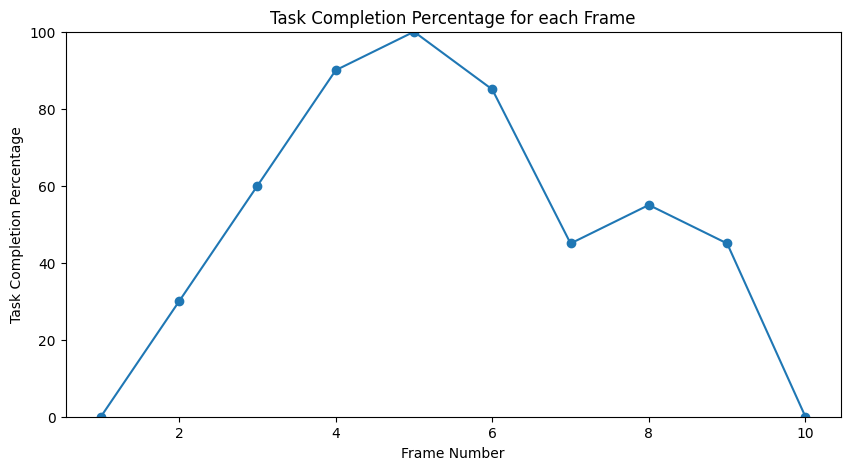

In [1227]:
frame_percentage = [(row['true_frame'], row['percentage']) for index, row in df.iterrows()]
frame_percentage.sort(key=lambda x: x[0])

#create line plot with markers
plt.figure(figsize=(10, 5))
plt.plot([x[0] for x in frame_percentage], [x[1] for x in frame_percentage], marker='o')
plt.ylim(0, 100)
plt.xlabel('Frame Number')
plt.ylabel('Task Completion Percentage')
plt.title('Task Completion Percentage for each Frame')
plt.show()